# Analyzing biasness towards (fe)male within TV show discussions by utilizing NLP and Word2Vec

### Operationalization: 2021/2022

Below you will find the list of the imported libraries for being able to use certain functions for desired usage.

In [1]:
import spacy
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import pandas as pd
import re
import random
import math

Explanation of library usage

- pandas: this package will be used to be able to read data, visualization of the results and managing data (transforming, adding, removing etc.)
- spacy: this package will be used for pre-processing task such as tokenization and cleaning text
- gensim: this package will be used to implement a Word2Vec model
- numpy: for manipulating arrays
- matplotlib: to visualize data within plot
- random: for random sampling of data
- math: to apply math methods such as sqrt of numerical values
- re: for applying regex, text cleaning

### Data set construction:

The dataset consists of tv show discussions over the years. The tv shows are mostly published on streaming services such as Netflix. The discussions are mostly about the storylines and the characters within the tv shows. Also, the pre-episode and after-episode. The streaming services has grown over the years including digital discussions about their most desired actors, movies and tv shows. Therefore, it can be interesting exploring the discussions about a tv show to get insights in the moving culture.

### Explanation about the choice of shows:
I chose The Witcher and Ozark. The reason for series The Witcher is that despite both genders appearing in the episodes, there are still 2 types of people. Namely, the men as knights surrounded by attractive women, earn coins by trading/ hunting and women who are magically strong. The second series is mainly about a family involved in money laundry and drugs. In both series I'm curious despite the characters and the storylines used if it creates bias within the discussions.

### Hypothesis:
The characters used for the series cause biased discussions towards genders.

### Word embedding model:
Since the question is about training a word embedding model and comparing gender biases within the discussions, I think Word2Vec is a suitable technique for this. Because this is a technique that is good at finding associations within a space of words and can therefore be used well to find the words associated with the genders.

## Phase 1: pre-processing steps and train word embedding models for each show

In this phase we will apply pre-processing techniques and train word embedding models for each show

### Step 1: read data and view the structure to get a idea about the data

In [2]:
# for being able to read framing.p data we have to call the function read_pickle
df_discussions = pd.read_pickle('../data/discussions.p')

In [3]:
# store the 2 shows for analysis purpose
tv_shows = ['The Witcher', 'Ozark']

# for having a quick idea about the data I'm working with
print(df_discussions.columns)
df_discussions[df_discussions.title.isin(tv_shows)].title.value_counts()

Index(['title', 'type', 'year', 'post'], dtype='object')


Ozark          1417
The Witcher    1188
Name: title, dtype: int64

### Step 2: pre-processing

We will apply a pre-processing step to gain the desired text format for training a Word2Vec model:

- Token text: I will use tokens instead of lemma and e.g. nouns because it might not help and make it harder for the model to predict a word when it is e.g. plural
- Lowercase: this is commonly used according to paper: 'How we do things with words analyzing text as Social and Cultural'
- Stopwords: for the pre-processing part stopwords won't be used because it won't make any significant difference since the frequency within Word2Vec would not consider it important and the corpora we are working with is small.
- Regex: for cleaning texts from escape characters, numerical values and urls.


In [4]:
def clean_text(text):
    # The regex has been tried first on https://regexr.com/
    # replaces a sequence of characters (http links, any non character e.g. numbers) with empty string
    new_text = re.sub('http\S+', '', text)
    return re.sub("[^a-zA-Z' ]+", '', new_text).strip()

def process_text(doc_v):
    # a function for extracting token as text and discarding punctuations plus empty strings
    # because of the cleaning process we have to expand the for loop

    # stores the cleaned version of the tokens
    new_tokens = []
    # iterates over each token within the document
    for token in doc_v:
        # remove punctuations
        if not token.is_punct:
            # clean text
            cleaned = clean_text(token.text)
            # don't store when the text is empty (with this we avoid unnecessary empty entries in an array)
            if len(cleaned) > 0:
                # because we don't know beforehand what size the new array will have (due to empty strings)
                # and the tokens are not very large we can use the function apply
                new_tokens.append(cleaned)
    return new_tokens

In [5]:
# first we load a nlp model for tokenization process
nlp = spacy.load("en_core_web_sm")

In [6]:
# Storing only the desired tv show discussions in a new dataframe for analysis purposes because they are the main focus
df_copied_discussions = df_discussions[df_discussions.title.isin(tv_shows)].copy()

In [7]:
%%time

# lowercase words before performing nlp
description_with_lowercase = df_copied_discussions.post.str.lower()

# number of processors to use for faster processing
n_process = 2
# bigger buffer in the memory for processing more data
batch_size=2000
# the features created by the components ner, parser won't be used (such as Token.ent_type, Token.dep) and therefore can be disabled (also for efficiency)
disable = ["ner", "parser"]

# compute nlp for extracting the tokens
processed_texts = [doc for doc in nlp.pipe(description_with_lowercase, n_process=n_process, batch_size=batch_size, disable=disable)]

CPU times: user 828 ms, sys: 107 ms, total: 935 ms
Wall time: 14.4 s


In [9]:
# storing the processed text in the dataframe for later usage (lemma, cleaning text and training topic model)
df_copied_discussions['processed_texts'] = processed_texts

# here I apply the function 'process_text' for getting tokens as text excluding punctuations
df_copied_discussions['tokens'] = df_copied_discussions.processed_texts.apply(lambda doc: process_text(doc))

### Step 3: train word embedding models for each tv show

Before training word embedding models we will first predefine the parameters and split de data into the chosen tv shows to train 2 models.

In [411]:
def train_word2vec(tokenized_texts):
    # function for training a word2vec model given tokenized texts

    # dimensions of the embeddings, 300 tend to be the most common dimensions used for embeddings
    SIZE = 300
    # we use skip-gram, using word to predict target context
    SG = 1
    # we use a maximum distance of 10 between a target word and words (contexts) around it and is usually around 10
    WINDOW = 10
    # number of workers (core to use) to use during training, the more, the faster
    N_WORKERS = 3
    # we want to ignore words with occurrence less than 2
    MIN_COUNT = 2

    # initialize a word 2 vec object
    model = Word2Vec(size=SIZE,
                    sg=SG,
                    window=WINDOW,
                    min_count=MIN_COUNT,
                    workers=N_WORKERS)

    # prepare vocabulary for the model
    model.build_vocab(tokenized_texts)

    # train word vectors
    model.train(tokenized_texts,
               total_examples=model.corpus_count,
               epochs=model.epochs)

    return model

In [412]:
%%time

# before training 2 models we have to split the tv shows into 2 dataframes
df_witcher = df_copied_discussions[df_copied_discussions.title == tv_shows[0]].copy()
df_ozark = df_copied_discussions[df_copied_discussions.title == tv_shows[1]].copy()

# here we train the model for each tv show
# because word2vec requires format of list of lists we can just give the columns containing on each row a list of tokens
model_witcher = train_word2vec(df_witcher.tokens)
model_ozark = train_word2vec(df_ozark.tokens)


CPU times: user 3.06 s, sys: 20.2 ms, total: 3.08 s
Wall time: 1.66 s


Now that the word embedding models are trained, we will move to phase 2 were we will compile a list of male and female related words and compare gender biases using the method of the paper by Wevers.

# Phase 2: compare gender biases

In this phase we will create (fe)male-related words and mean embeddings of those words. Furthermore, we will use the method of the paper by Wevers to get an indication of the gender bias related to a certain category and compare the results of the 2 tv shows.

### Step 1: (fe)male-related words and mean embeddings

In [414]:
def gender_ratio(sentence_v):
    male = 0
    female = 0
    for sentence in sentence_v:
        splitted = sentence.lower().split()
        # here we only count on sentence level, so not how many times a word occurs in a sentence
        if splitted.count('male') > 0:
            male += 1

        if splitted.count('female') > 0:
            female += 1

    return male, female

def frobenius_dist(w1, w2):
    # function for calculating the difference between 2 words
    return np.linalg.norm(np.subtract(w1, w2))

def mean_embedding(gender_related_words, trained_model):
    # checks if word is in vocabulary (i.e. has been seen by the model before)
    return np.mean([trained_model.wv[word] for word in gender_related_words if word in trained_model.wv.vocab], axis=0)

def get_bias_result(model, gender_related_words, category):
    # code source: https://github.com/melvinwevers/historical_concepts
    # the code is needed from the source of Wevers to be able to calculate the bias towards genders

    # function for getting the bias results given a model, gender related words and category

    # stores the category word and the related bias score
    dict_word_bias = {}

    # calculates mean embedding
    mean_emb_male = mean_embedding(gender_related_words[0], model)
    mean_emb_female = mean_embedding(gender_related_words[1], model)

    # loop over each category word
    for category_w in category:
        if category_w in model.wv.vocab:
            # get vector representation of a category word
            cat_word_vector = model.wv[category_w]

            # calc distance between word embedding and category word
            frob_dist_male = frobenius_dist(mean_emb_male, cat_word_vector)
            frob_dist_female = frobenius_dist(mean_emb_female, cat_word_vector)

            # here we subtract male dist - female dist
            C = [x_ - y_ for x_, y_ in zip([frob_dist_male], [frob_dist_female])]

            # here we store the mean of the subtraction to get an idea of biased category words
            dict_word_bias[category_w] = np.mean(C)

    return dict_word_bias

In [415]:
# read in word_cats
df_word_cats = pd.read_pickle('../data/word_cats.p')
df_word_cats.columns

Index(['affect', 'posemo', 'negemo', 'social', 'family', 'cogproc', 'percept',
       'body', 'work', 'leisure', 'money', 'relig', 'occupation'],
      dtype='object')

In [416]:
# compiled (fe)male-related words
male_related = ['he', 'his', 'muscular', 'male', 'gentlemen', 'king', 'fighter', 'witcher', 'father', 'son', 'husband', 'violence', 'hunter', 'blood', 'musician', 'assassin', 'cartel', 'mafia']
female_related = ['she', 'her', 'beauty', 'female', 'lady', 'queen', 'magician', 'sorceress', 'mother', 'daughter', 'elf', 'abuse', 'dark', 'curse', 'mind', 'teenage', 'sex', 'cheating']

len(male_related), len(female_related)

(18, 18)

In [492]:
# Before proceeding to step 2 we are interested in what we can expect
# according to the gender occurrence in witcher we can expect slightly bias towards male and in ozark towards female
gender_ratio(df_witcher.post), gender_ratio(df_ozark.post)

((2, 1), (3, 5))

### Step 2: get bias results per model

Here we use the method of Wevers for getting the biasness per category word

In [418]:
# for each model get the biasness per category word
df_bias_witcher = get_bias_result(model=model_witcher, gender_related_words=[male_related, female_related], category=df_word_cats.money)
df_bias_witcher = pd.DataFrame(df_bias_witcher.items(), columns=['category_word', 'bias_score'])

df_bias_ozark = get_bias_result(model=model_ozark, gender_related_words=[male_related, female_related], category=df_word_cats.money)
df_bias_ozark = pd.DataFrame(df_bias_ozark.items(), columns=['category_word', 'bias_score'])

### Step 3: analyze bias towards gender per tv show

First we will analyze/ interpret one category named money because The Witcher earns his coins by hunting and Ozark is mostly about money laundry.

Text(0.5, 1.0, 'Word bias towards gender in Ozark')

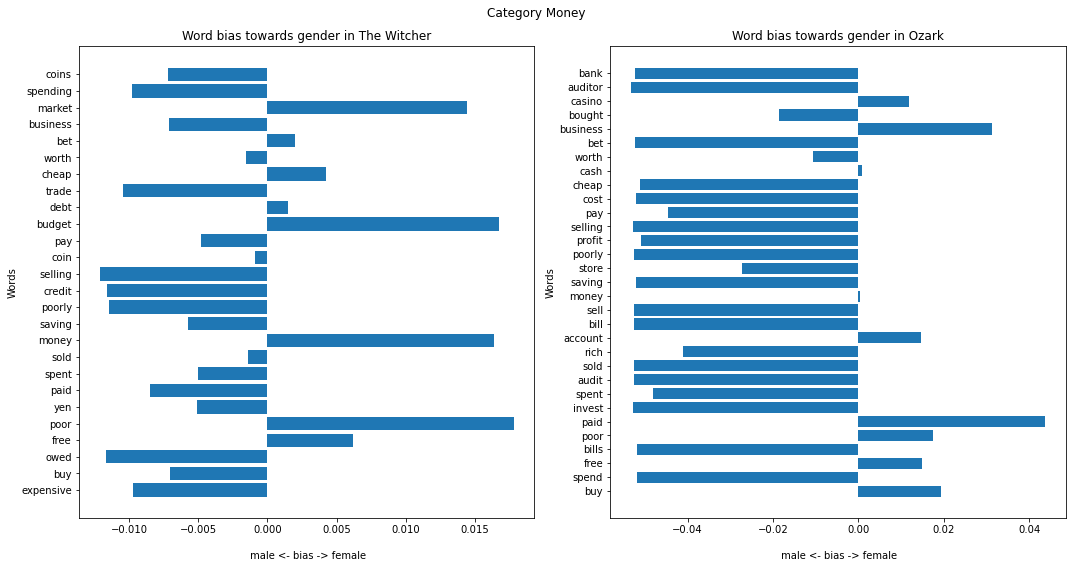

In [493]:
# preparing subplots so we can render the bar plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), tight_layout=True)

fig.suptitle('Category Money')

x_axis_label = '\n male <- bias -> female'
y_axis_label = 'Words'

y_pos1 = np.arange(len(df_bias_witcher.category_word))
ax1.barh(y_pos1, df_bias_witcher.bias_score)
ax1.set_yticks(y_pos1)
ax1.set_yticklabels(df_bias_witcher.category_word)
ax1.invert_yaxis()
ax1.set_xlabel(x_axis_label)
ax1.set_ylabel(y_axis_label)
ax1.set_title('Word bias towards gender in The Witcher')

y_pos2 = np.arange(len(df_bias_ozark.category_word))
ax2.barh(y_pos2, df_bias_ozark.bias_score)
ax2.set_yticks(y_pos2)
ax2.set_yticklabels(df_bias_ozark.category_word)
ax2.invert_yaxis()
ax2.set_xlabel(x_axis_label)
ax2.set_ylabel(y_axis_label)
ax2.set_title('Word bias towards gender in Ozark')

According to the paper of Wevers, the positive values meaning bias towards woman and negative meaning biased towards men.

### Interpretation:

From the result we can see that there are more biased words towards male in Ozark and Witcher. With tv show Ozark we would expect to see less bias within the category Money because the family is involved in situations surrounding money laundry. And in Witcher we would expect all words bias towards male due to the male actor earning coins by hunting and trading. Surprisingly, we see in Witcher that the word money is biased towards female.

The hypothesis is: 'The characters used for the series cause biased discussions towards genders.' and when we look at the category money then we can conclude that both tv shows come with interesting result due to mostly male characters associated with category money. But for Ozark, the results are unexpected because the characters are usually a family involved in money-laundering situations, so we wouldn't expect a bias that is mostly male-oriented. This can mean 2 things for Ozark, 1: in the 'series' the male mainly deals with money situations within the family or 2: in the 'discussions' people usually associate the category money with male.


### Step 4: what is the bias occurrence between genders per category

Here we will look at the bias occurrence between genders per category and compare both tv shows. The goal is to get a visual understanding of the distribution of bias in both tv shows.

In [420]:

def get_gender_bias_count(values, negative):
    # function that counts negative or positive values
    x = np.array(list(values))
    return np.count_nonzero(np.extract((x < 0 if negative else x > 0), x))

# for storing per category per gender the occurrence in bias differences
witcher_category_occurrence = pd.DataFrame(columns=df_word_cats.columns)
ozark_category_occurrence = pd.DataFrame(columns=df_word_cats.columns)

# loop over each category from Wevers
for index, column in enumerate(df_word_cats.columns):
    category_w = df_word_cats[column]

    # get bias result for each tv show
    dict_bias_witcher = get_bias_result(model=model_witcher, gender_related_words=[male_related, female_related], category=category_w)
    dict_bias_ozark = get_bias_result(model=model_ozark, gender_related_words=[male_related, female_related], category=category_w)

    # count the bias occurrences for each gender
    witcher_category_occurrence.loc['M', column] = get_gender_bias_count(dict_bias_witcher.values(), True)
    witcher_category_occurrence.loc['F', column] = get_gender_bias_count(dict_bias_witcher.values(), False)

    ozark_category_occurrence.loc['M', column] = get_gender_bias_count(dict_bias_ozark.values(), True)
    ozark_category_occurrence.loc['F', column] = get_gender_bias_count(dict_bias_ozark.values(), False)


In [421]:
# here we get a first glance on the distribution of categories together with the bias occurrence towards genders
ozark_category_occurrence

,affect,posemo,negemo,social,family,cogproc,percept,body,work,leisure,money,relig,occupation
M,163,83,74,99,14,139,58,16,45,36,22,9,9
F,74,34,39,66,7,119,29,6,11,9,9,2,5


In [422]:
# here we get a first glance on the distribution of categories together with the bias occurrence towards genders
witcher_category_occurrence

,affect,posemo,negemo,social,family,cogproc,percept,body,work,leisure,money,relig,occupation
M,106,45,58,67,5,95,39,17,23,17,18,5,8
F,104,60,43,79,7,156,39,11,13,20,8,3,2


For readability, we will plot the results

<AxesSubplot:title={'center':'Ozark: bias gender ratio over the categories'}>

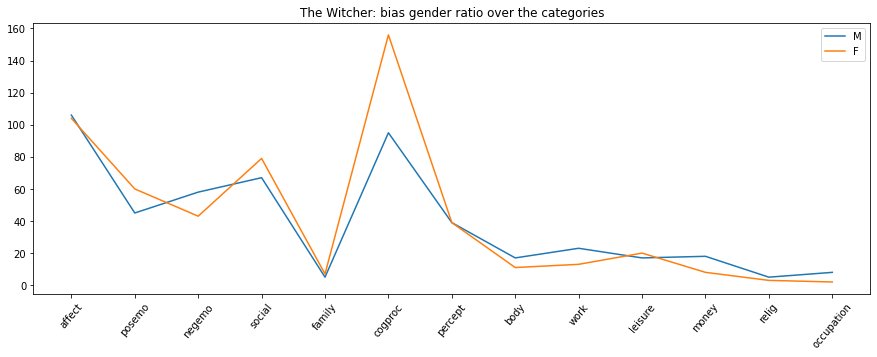

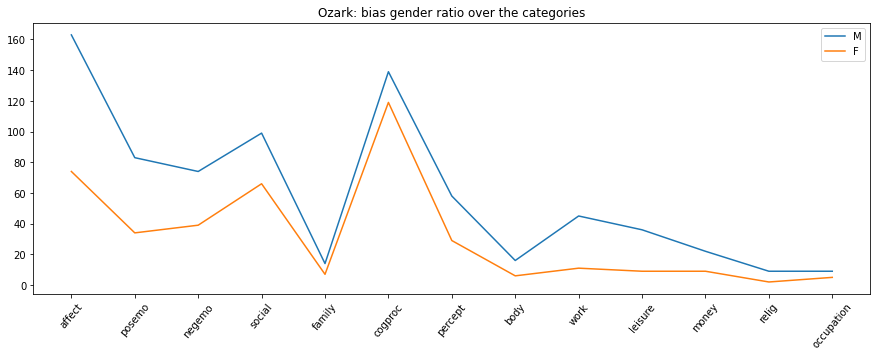

In [423]:
witcher_category_occurrence.T.plot(xticks=range(0, len(witcher_category_occurrence.columns)), rot=50, title='The Witcher: bias gender ratio over the categories', figsize=(15, 5))
ozark_category_occurrence.T.plot(xticks=range(0, len(ozark_category_occurrence.columns)), rot=50, title='Ozark: bias gender ratio over the categories', figsize=(15, 5))

### Interpretation:

The result in the plots show us that in both series there are bias towards both genders. The bias difference is more in the categories such as affect, posemo, negemo, work and social towards male for Ozark compared with Witcher. In some categories, both series show similar pattern in bias towards female, but differ in the number of biased words. For category cogproc Witcher has more biased words towards female whereas Ozark has nearly similar bias in both genders. According to the results and the hypothesis we might say that the bias is within the discussions. But on the other hand, the bias within the discussions could also be due to the characters that have been created by the tv shows. To have a closer look we will have to plot the same visualizations created within the paper of Wevers were we can see the biased words towards gender per category.

### Step 5: analyze biased words towards gender per category
Here we apply the method of Wevers for plotting the word bias towards genders. As you'll notice, I've modified the code in a way that I can use it. Otherwise, because Wevers' method is not generic, it will throw errors and not render all categories due to difference in random sample vector sizes. To solve this problem I transformed the method in a more generic fashion to make it work regardless the size of the vectors.

In [521]:

def plot_gender_bias(model, df):
    # code source: https://github.com/melvinwevers/historical_concepts
    # I had to modify the code to make it suitable for my case

    # A function to plot each category together with the related word in the vocab and the biasness towards genders

    # to create n x n matrix for sub-plotting purposes
    rounded_root = round(math.sqrt(len(df.columns)))
    # because the grid for subplot has to be balanced we have to add the missing 'matrix cell' to make it balance and then at the bottom of this function we remove those subplots
    columns = df.columns.values.tolist() + ['x' for _ in range(0, rounded_root - 1)]
    # here we reshape the array so we can iterate as we iterate over a grid of subplots
    columns = np.array(columns).reshape([rounded_root, rounded_root])

    # calc mean embedding
    mean_emb_male = mean_embedding(male_related, model)
    mean_emb_female = mean_embedding(female_related, model)

    # create subplots
    fig, axes = plt.subplots(rounded_root, rounded_root, figsize=(20, 20), tight_layout=True)

    # loop over column name vector on each row (subplot)
    for idx, column_names in enumerate(columns):
        # loop over column name within the vector
        for idy, column_name in enumerate(column_names):
            # if we face a missing 'matrix cell' we skip rendering the plot (which causes empty subplots but thats also the idea so we can remove it at the bottom of this function)
            if column_name == 'x':
                # break so we directly stop iterating because the all next entries are just missing 'matrix cells'
                break

            # get category related words
            category_words = df[column_name]

            # store frob dist values
            male_values = []
            # store frob dist values
            female_values = []
            # store category word that exist in the vocab
            category_words_in_vocab = []

            # loop over each category word
            for category_w in category_words:

                # if the word is in vocab then proceed the computation
                if category_w in model.wv.vocab:
                    # get vector representation
                    cat_word = model.wv[category_w]

                    # calc distance between word embedding and category word
                    frob_dist_male = frobenius_dist(mean_emb_male, cat_word)
                    frob_dist_female = frobenius_dist(mean_emb_female, cat_word)

                    # save the mean distance of male and category word to analyse if a word is biased towards a gender
                    male_values.append(frob_dist_male)
                    female_values.append(frob_dist_female)
                    category_words_in_vocab.append(category_w)

            # here we subtract male dist - female dist
            C = [x_ - y_ for x_, y_ in zip(male_values, female_values)]

            # here we define the properties for rendering the plot
            ax = axes[idx, idy]
            ax.set_xlabel('distance to male')
            ax.set_ylabel('distance to female')

            min_female_values = float(min(female_values) - 0.05)

            # get indices vector for the random sampling and N words to be projected on the subplot
            top_sample = list(np.argsort(C)[-50:])
            bottom_sample = list(np.argsort(C)[:50])

            # generate random sampling
            top_idx = random.sample(top_sample, len(top_sample)) # <----- this was causing issue before but with my solution it's now generic and works (it was hardcoded)
            bottom_idx = random.sample(bottom_sample, len(bottom_sample)) # <----- this was causing issue before but with my solution it's now generic and works (it was hardcoded)

            # loop over each category word and project it on a position within the plot
            for i, label in enumerate(category_words_in_vocab):
                if i in top_idx or i in bottom_idx:
                    ax.annotate(f'o {label}', (male_values[i], female_values[i]))

            ax.title.set_text(f'Category: {column_name}')
            ax.grid(True)
            ax.plot([min_female_values, max(male_values) + 0.05], [min_female_values, max(male_values) + 0.05], ls="--", c=".3")

    # removes unused subplots
    for index in range(1, 4):
        fig.delaxes(axes[3][index])


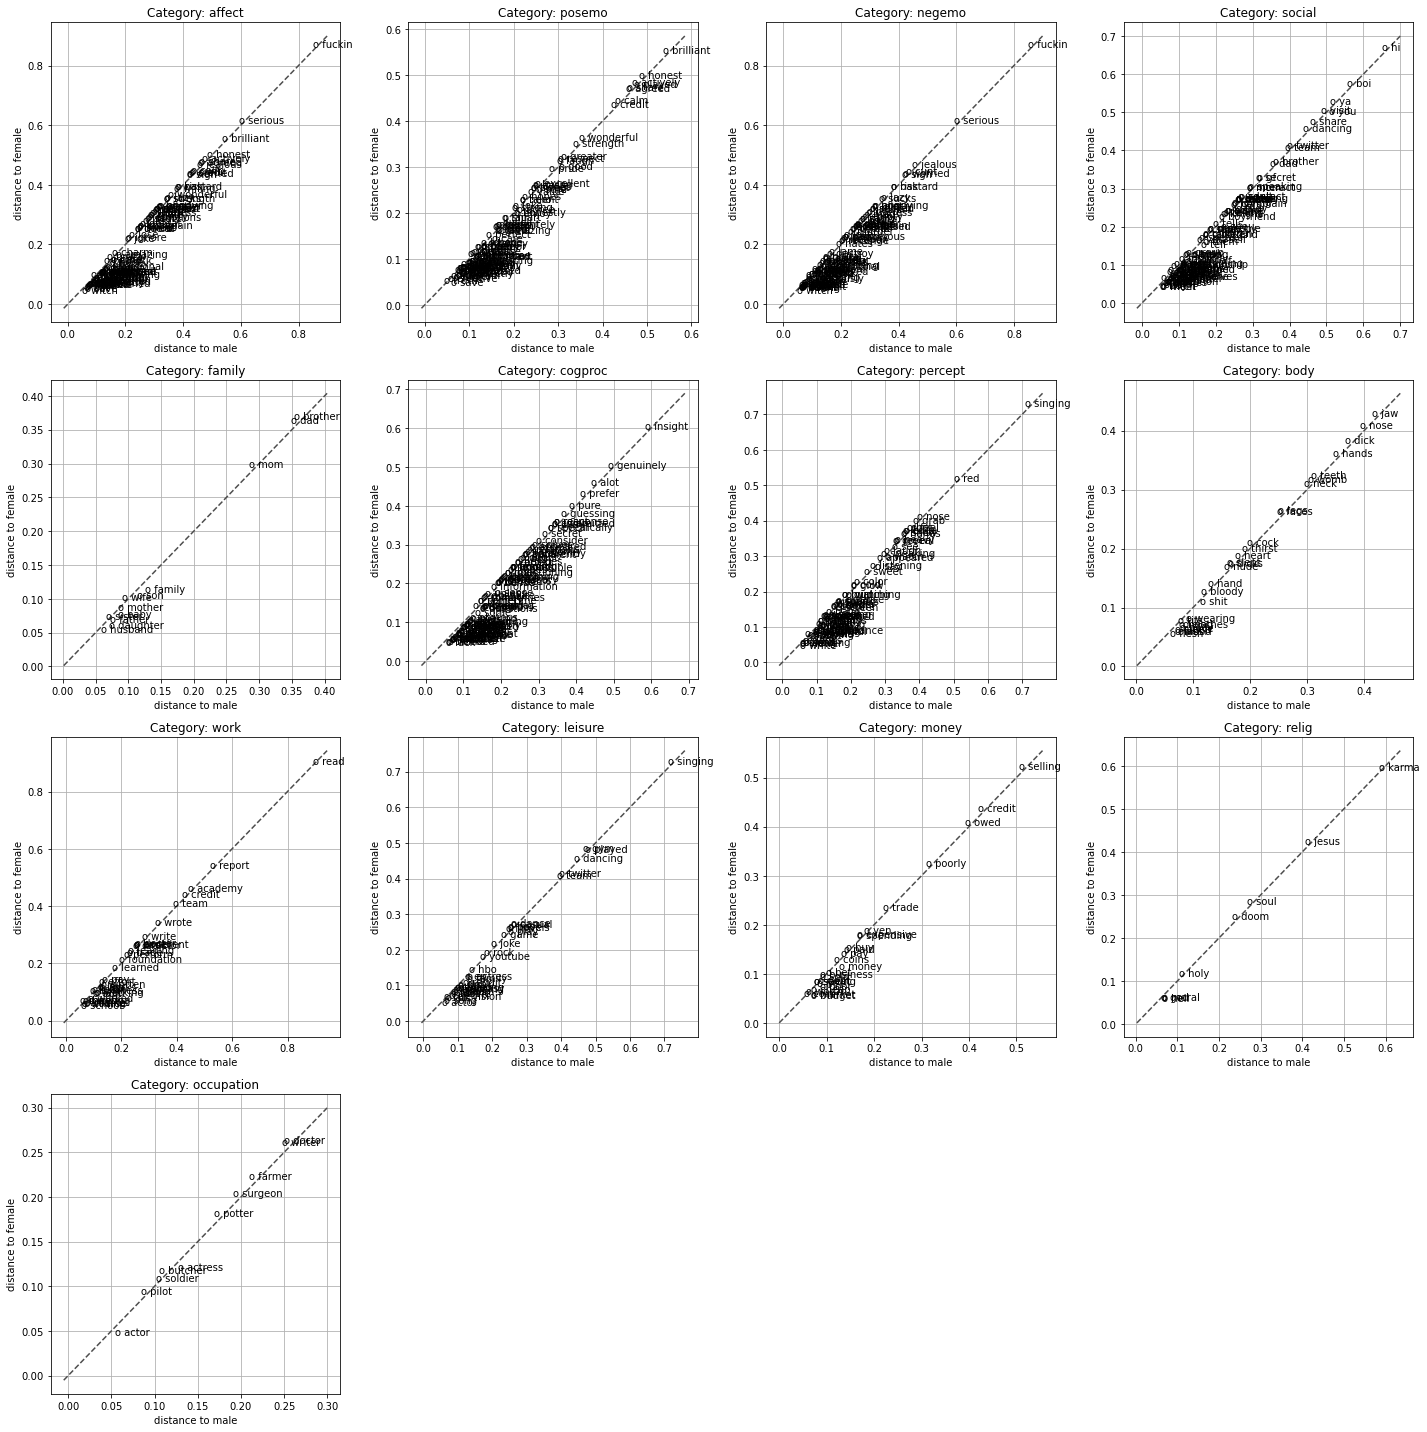

In [522]:
plot_gender_bias(model_witcher, df_word_cats)

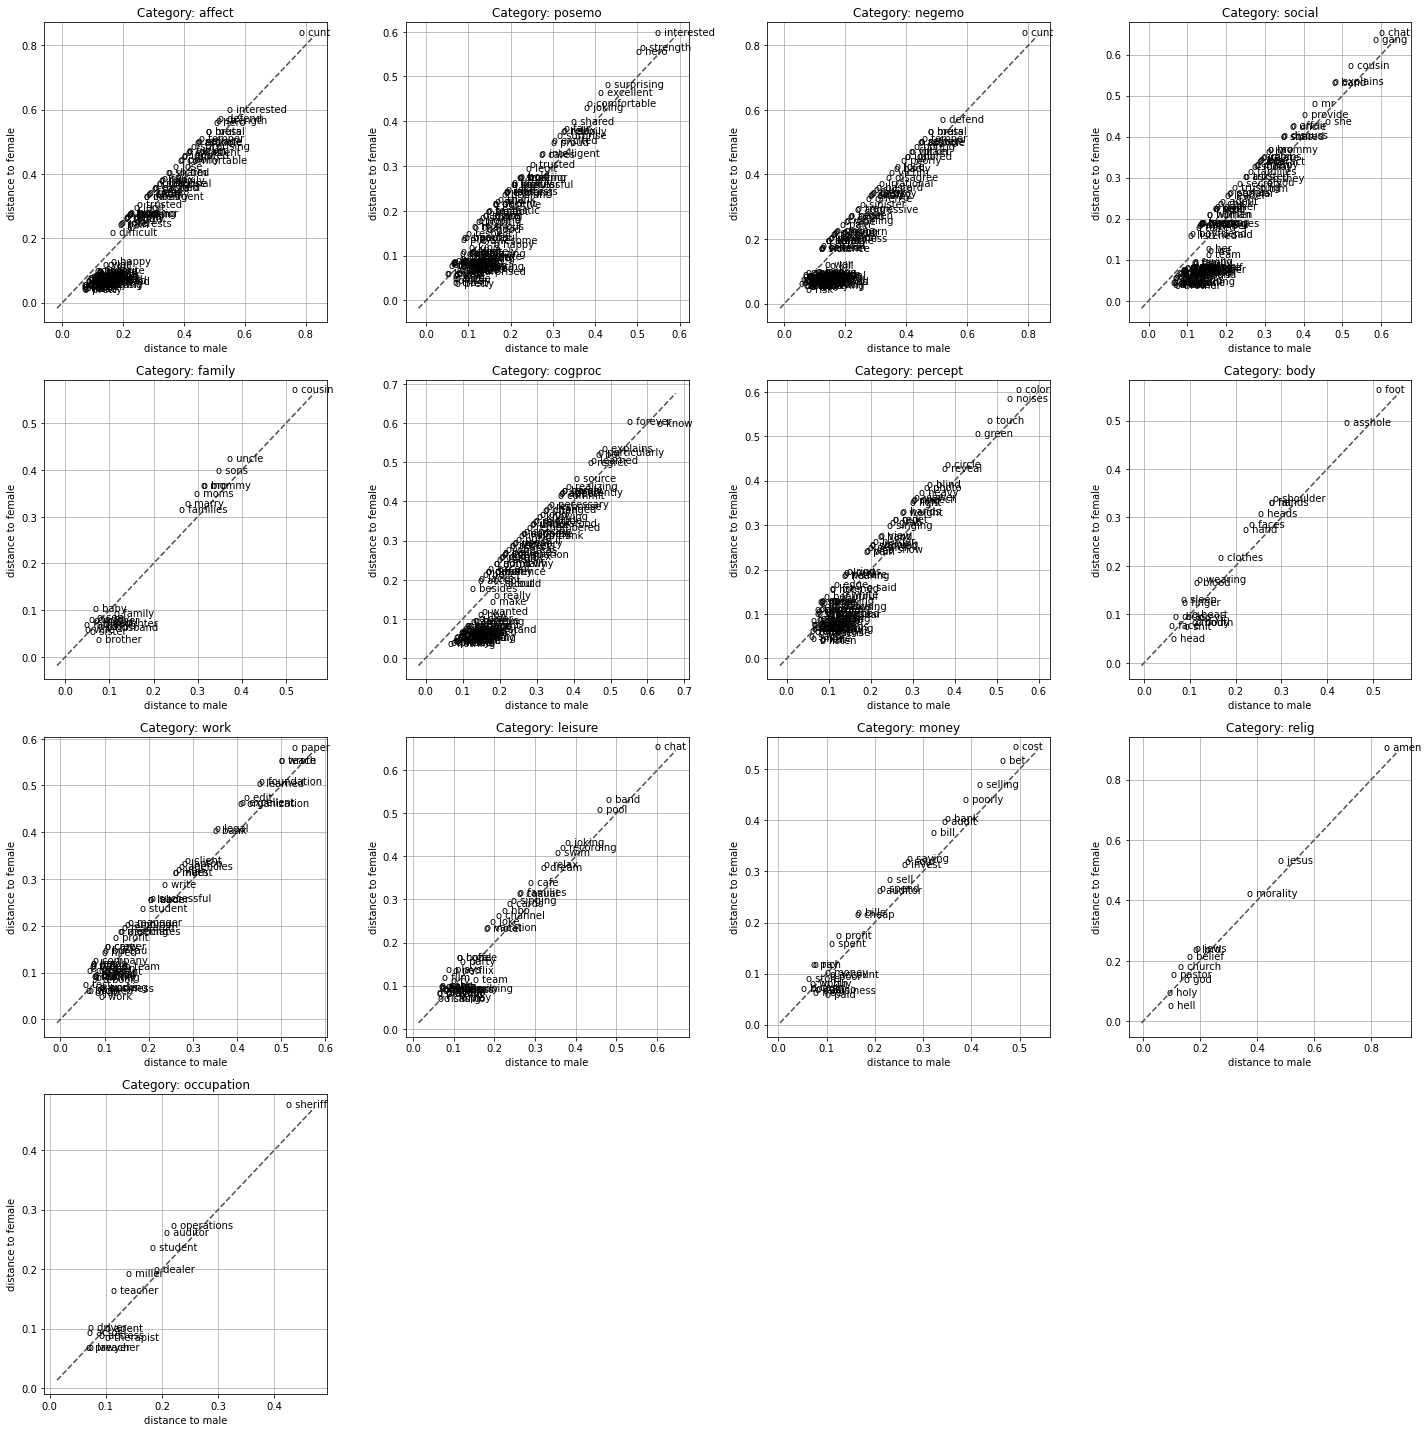

In [523]:
plot_gender_bias(model_ozark, df_word_cats)

### Interpretation/ discussions:

From the result we can see that in Witcher both female and male have similar amount of biased words which we saw earlier as well in the bias occurrence plot. However, we see that with category cogproc there is more biasness towards female which is slight difficult to see by using the plot from Wevers, but if you look carefully then you will see a thick black cloud of words at the bottom left. Furthermore, in Witcher looking at the category body we see more biasness towards male which are the words just above the diagonal line. These words, however, outline the characters of the lead actor (who is muscular) in the series such as bloody, cock (due to erotic scene), jaw, nose and hands. In contrast, in the series Ozark we see that there is more biasness towards male. As we have seen from the bias occurrence plot the categories of biasness for male are affect, posemo, negemo, social, work and leisure. Some of them are hardly to see in the word plots, but they are clearly above the diagonal line meaning that they are biased towards men. Looking at a more readable category such as money we see words like bet, selling, bill, bank, cost etc. being associated with male. These words draw the characters of the series because of the money laundry and drug scenes. Finally, the series Ozark show similar pattern for both genders but with different number of biased words for each gender and leans more towards male whereas The Witcher shows similar number of biases for both genders and leans for one category more towards female. As a follow-up, it could be interesting to gain an insight into the genders involved in discussions in order to get for example a proportion of discussions by genders together with the tv show they watched.

### Documents consulted:

- arXiv:1907.08922: Using Word Embeddings to Examine Gender Bias in Dutch Newspapers, 1950-1990
- https://github.com/melvinwevers/historical_concepts